In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real

In [2]:
def get_power1(Gamma):
    return Gamma[:,0,0].real

def get_power1dB(Gamma):
    return 10*np.log10(Gamma[:,0,0].real)

def get_coh(Gamma):
    return thr_coherence(Gamma)


from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [3]:
mu = 0.0
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
ov1 = 1.0
ov2 = -2.0


In [4]:
import os
import jax.numpy as jnp
import jax.random as jr
from cohlib.utils import gamma_root
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0


lseed = 7
oseed = 7
flow = 1
fhigh = 50
sp_target = 5
sp_offtarget = 1
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
N = freqs.size
nz = gamma_load['nonzero_inds']
nz_target = jnp.array([9])
K = gamma_full.shape[-1]

lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

ork = jr.key(oseed)


print(f"Sampling observations with variance {ov1}e^{ov2}")
obs_var = ov1 * 10**ov2
# obs_var = ocfg.ov1 * 10**{ocfg.ov2}
jax_ys = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)
ys = np.array(jax_ys)[:,None,:,:]

Sampling observations with variance 1.0e^-2.0


In [5]:
ov2 = -2.0



seed = 8
etype="approx"
model_path = f'saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
model_load = pickle_open(model_path)

Wv_model = model_load['Wv']
Wv = Wv_model
num_J_vars = Wv.shape[1]
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int((Wv.shape[1])/2)


In [6]:
# from cohlib.mvcn import sample_mvcn_time_obs_nodc
# data_check_path = f'saved/synthetic_data/simple_synthetic_gaussian_2_25_1000_1_0.0_1.0_0.0_7' 
# check = pickle_open(data_check_path)
# nz = np.arange(50)
# Gamma_reduce = check['latent']['Gamma'][nz,:,:]
# freqs_reduce = freqs[nz]
# Wv_reduce = Wv

# check_xs, check_vs, check_zs = sample_mvcn_time_obs_nodc(Gamma_reduce, L, freqs_reduce, Wv_reduce, return_all=True)
# # S = check['latent']['Gamma'][:,0,0].real
# # plt.plot(S)
# # # plt.ylim([0,500])
# # plt.xlim([0,50])

In [7]:
# test = Wv.T @ ys[:,0,0,0]
vs_from_ys = jnp.einsum('jt,tkl->jkl', Wv.T, ys[:,0,:,:])
zs_from_ys = conv_v_to_z(vs_from_ys, axis=0)
gamma_from_ys = jnp.einsum('jkl,jil->jkil', zs_from_ys, zs_from_ys.conj()).mean(-1)

Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
# zs_naive = jnp.fft.rfft(ys, axis=0)[1:,0,:,:]
# gamma_naive = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

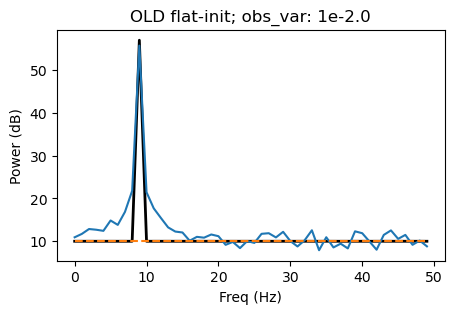

In [15]:
dB = True
ov2 = -1.0
seed = 8
etype="analytical"
ovs = [-2]
# ovs = [-3, -2, -1, 0]
for ov2 in ovs:
    ov2 = float(ov2)
    model_path = f'saved/fitted_models/corrected_scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_load = pickle_open(model_path)

    fig, ax = plt.subplots(figsize=(5,3))
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500
    S_model = model_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_init = Gamma_init[:,0,0].real 
    S_true = gamma_full[:50,0,0].real 
    # S_naive = gamma_from_ys[:,0,0].real * (((J * np.pi)**2 / (J + 1)))

    if dB is True:
        S_model = 10*np.log10(S_model)
        S_init = 10*np.log10(S_init)
        # S_naive = 10*np.log10(S_naive)
        S_true = 10*np.log10(S_true)

    ax.plot(S_true, 'k', linewidth=2, label='True')
    # ax.plot(S_oracle, 'tab:green', label='Oracle')
    ax.plot(S_model, 'tab:blue', label='Model')
    ax.plot(S_init, 'tab:orange', linestyle='--', label='Model')
    ax.set_title(f'OLD flat-init; obs_var: 1e{ov2}')
    ax.set_xlabel('Freq (Hz)')
    if dB is True:
        ax.set_ylabel('Power (dB)')
    else:
        ax.set_ylabel('Power ')
    if ov2 == -3:
        ax.legend()
    # plt.xlim([0,5])

In [6]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))
def get_Qs_real_new(o1, o2,
                e_step_type='analytical', 
                sample_length=1000,
                L=25,
                C=1,
                em_iters=10,
                K=2):

    if e_step_type == 'analytical':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_em{em_iters}_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}_fitted_analytical'
    else:
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_em{em_iters}_{K}_{L}_{sample_length}_{C}_{mu}_{o1}_{o2}_{seed}_fitted'

    Qs = []
    model_load = pickle_open(model_path)
    Gamma_inv_init = model_load['inv_init']
    Gamma_init = deconstruct_Gamma_full_real(Gamma_inv_init, K, num_J_vars, invert=True)

    Wv = model_load['Wv']
    ys = model_load['ys_Cavg']

    T = Wv.shape[0]


    As = []
    Bs = []
    for r in range(em_iters):
        print(r)
        gamma_rplus1 = model_load['track'][0][r]['gamma_rplus1']
        J = gamma_rplus1.shape[0]
        # gamma_rplus1_inv = np.stack([np.linalg.inv(gamma_rplus1[j,:,:]) for j in range(gamma_rplus1.shape[0])])
        gamma_rplus1_inv = np.linalg.inv(gamma_rplus1)
        sig_r = model_load['track'][0][r]['Sig_complex']
        mus_r = model_load['track'][0][r]['mus']
        Ups_invs_r = model_load['track'][0][r]['Ups_invs']

        gamma_real_rplus1 = np.stack([quick_conv_c2r(gamma_rplus1[j,:,:],K) for j in range(J)])
        gamma_real_rplus1_inv = np.stack([quick_conv_c2r(gamma_rplus1_inv[j,:,:],K) for j in range(J)])

        sig_real_r = np.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = np.stack([quick_conv_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r[l,:,:,:] = sig_real_rl

        obs_var = o1 * (10**o2)
        Q_mat = np.diag(np.ones(T)*obs_var)
        Q_mat_inv = np.diag(np.ones(T)*(1/obs_var))

        # A, B, Q = Q_func_real(gamma_real_rplus1, gamma_real_rplus1_inv, sig_real_r)
        A, B, Q = Q_func_real_new(Wv, ys, Q_mat, Q_mat_inv, mus_r, Ups_invs_r, gamma_real_rplus1, gamma_real_rplus1_inv, sig_real_r)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return np.array(Qs) 
    return As, Bs, np.array(Qs) 

def Q_func_real_new(Wv, ys, Q_mat, Q_mat_inv, mus_r, Ups_invs_r, Gamma_real_r, Gamma_real_r_inv, Sigmas_real_r, delta=1e-3):
    num_J_vars = Wv.shape[1]
    data = ys.squeeze()
    L = Sigmas_real_r.shape[0]
    K = data.shape[1]
    T = ys.shape[2]
    num_J_vars = Wv.shape[1]
    # print(K)
    obs_var = Q_mat[0,0]

    for l in range(L):
        mu_l = mus_r[l,:]
        Ups_inv_l = Ups_invs_r[l,:,:]
        Ups_l = np.diag(1/np.diag(Ups_inv_l))

    obsQ_sumA = L*((T)*np.log(2*np.pi) + np.log(obs_var)) 

    xs_r = np.zeros((L,K,T))
    obsQ_sumB = 0
    for k in range(K):
        mus_k = mus_r[:,k*num_J_vars:k*num_J_vars+num_J_vars]
        xs_k = (Wv @ mus_k.swapaxes(0,1)).swapaxes(0,1)
        xs_r[:,k,:] = xs_k
        innovations = ys[:,k,:] - xs_r[:,k,:]
        obsQ_sumB += np.trace(Q_mat_inv @ (innovations.T @ innovations))


    obsQ = -(1/2)*(obsQ_sumA)  + -(1/2)*(obsQ_sumB)

    latentQ_sumA = L*( ((2*K)*np.log(2*np.pi) + np.log(np.linalg.det(Gamma_real_r)))).sum()
    # sum_A = L*np.log(2*np.pi**K * (1/np.linalg.det(Gamma_real_r_inv))).sum()
    latentQ_sumB = np.trace(Gamma_real_r_inv @ Sigmas_real_r, axis1=2, axis2=3).sum()
    latentQ = -(1/2)*(latentQ_sumA)  + -(1/2)*(latentQ_sumB)

    Q = obsQ + latentQ

    return obsQ, latentQ, Q

In [7]:
As, Bs, Qs = get_Qs_real_new(1.0, 0.0)

0
1
2
3
4
5
6
7
8
9


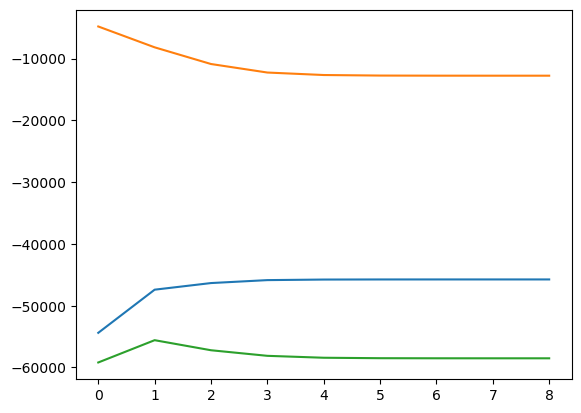

In [35]:
plt.plot(As[1:])
plt.plot(Bs[1:])
plt.plot(Qs[1:])

(0.0, 5.0)

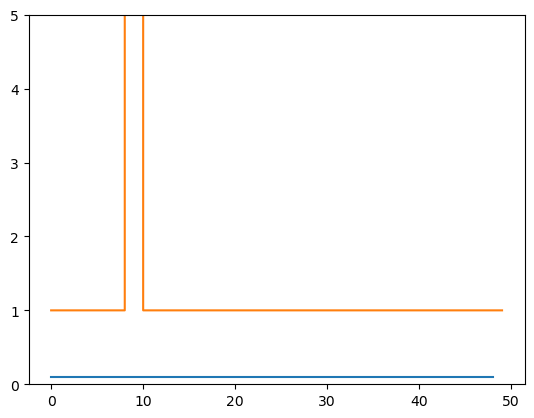

In [27]:
Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)
Gamma_init.shape
plt.plot(Gamma_init[:50,0,0].real)
plt.plot(Gamma_true[:50,0,0].real)

plt.ylim([0,5])

### what do we need to plot Q-function?
- At end of iteration R (so M-step has been performed and the update is $\Gamma^{(r+1)}$) we need:
    - $\mathbf{Q}$ inverse - observation noise variance
    - $\mathbf{y^{k,\ell}}$ - observed data
    - $\mathbf{W}$ - inv Fourier matrix used
    - $\mathbf{\hat{v}}^{k,\ell}$ - expected values for $\mathbf{v}^{k,\ell}$
    - $\mathbf{\hat{\Sigma}}^{\ell}_j$ - expected values for $\mathbf{v^{k,\ell}v^{k,\ell}}^{\top}$
    - $\Gamma^{(r+1)}$

In [77]:
data_load['observed']['var']

1.0

(0.0, 1200.0)

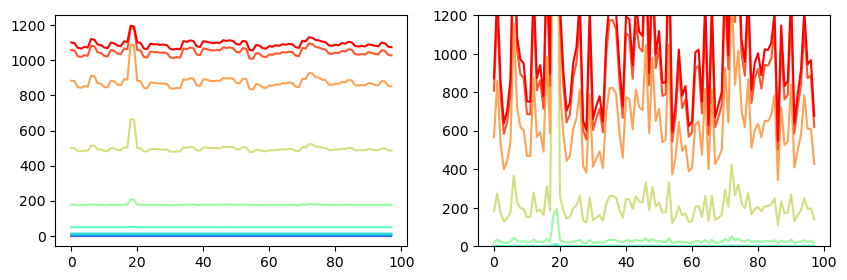

In [8]:
R = 10
fig, ax = plt.subplots(1,2,figsize=(10,3))
color = plt.cm.rainbow(np.linspace(0, 1, R))
for r in range(R):
    track_r = model_load['track'][0][r]
    Ups_invs_r = track_r['Ups_invs']
    Ups_r_diag = np.stack([1/np.diag(Ups_invs_r[l,:,:]) for l in range(L)])

    mus_r = track_r['mus']
    mus_outer_r_diag = mus_r**2

    ax[0].plot(Ups_r_diag[:,:98].mean(0), color=color[r])
    ax[1].plot(mus_outer_r_diag[:,:98].mean(0), color=color[r])

ax[1].set_ylim([0,1200])

In [9]:
Obs_noise = np.diag(Ups_r_diag.mean(0))

In [10]:
num_J_vars = int(2*(Wv.shape[1]/K))

In [11]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real

Obs_noise_power = deconstruct_Gamma_full_real(Obs_noise, K, num_J_vars)

In [12]:
Obs_noise_power[:,0,0].real

array([2200.59062504, 2138.73086818, 2150.34349069, 2239.26454967,
       2178.0823761 , 2143.55561312, 2198.25376155, 2165.62329379,
       2213.98502367, 2390.12233539, 2203.03111161, 2131.47522641,
       2186.63469203, 2180.39871061, 2176.79830435, 2127.19078659,
       2129.43977098, 2215.70058945, 2224.09428218, 2156.7208467 ,
       2215.08222675, 2200.2762871 , 2200.8101303 , 2226.01576825,
       2224.9667391 , 2182.81919887, 2217.91164424, 2116.23207281,
       2171.5347304 , 2136.21660983, 2159.46939117, 2169.60129735,
       2181.67066855, 2185.19026224, 2146.48257632, 2220.40869485,
       2260.62376981, 2230.357611  , 2212.06651045, 2168.44478856,
       2175.90714411, 2193.20183973, 2208.63137849, 2160.94372373,
       2161.91988173, 2179.46007169, 2162.87924958, 2198.73759537,
       2153.28438289])

In [13]:
Gamma_est = model_load['Gamma']

/scratch/265123.1.ood/ipykernel_2419070/3783799076.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(Gamma_true[:,0,0].real), 'k', label='True')


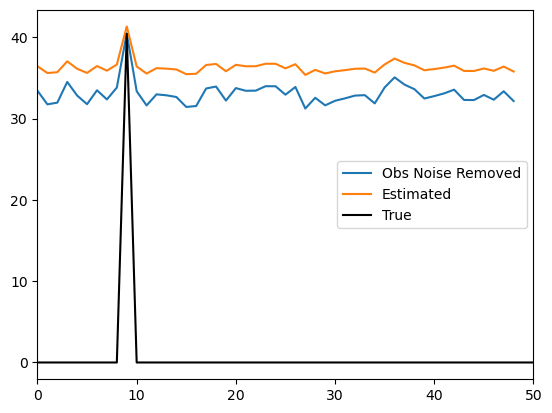

In [32]:
plt.plot(10*np.log10(Gamma_est[:,0,0].real - Obs_noise_power[:,0,0].real), label='Obs Noise Removed')
plt.plot(10*np.log10(Gamma_est[:,0,0].real), label='Estimated')
plt.plot(10*np.log10(Gamma_true[:,0,0].real), 'k', label='True')
plt.xlim([0,50])
plt.legend()

In [37]:
np.log(1200)

7.090076835776092

In [6]:
func = get_power1dB
Gamma_true = Gamma
func_true = func(Gamma_true[:J_max,:,:])
# func_naive = func(naive[1:J_max+1,:,:])
# model_est = model_load['Gamma']
# func_model = func(model_est)

direct_est = Gamma_est_from_zs(zs[:,:,:J_max+1], dc=False)
func_zs = func(direct_est)

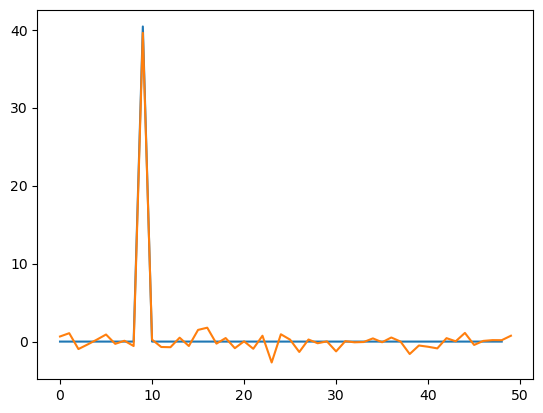

In [7]:
plt.plot(func_true)
plt.plot(func_zs)

In [8]:
model_load['Wv'].shape

(1000, 99)

In [9]:
from scipy.fft import rfft
xs_ft = rfft(xs, axis=2)
ys_ft = rfft(ys_avg, axis=2)


/projectnb/stephenlab/jtauber/cohlib/cohlib/mvcn.py:218: RuntimeWarning: invalid value encountered in divide
  t_coh = num/denom


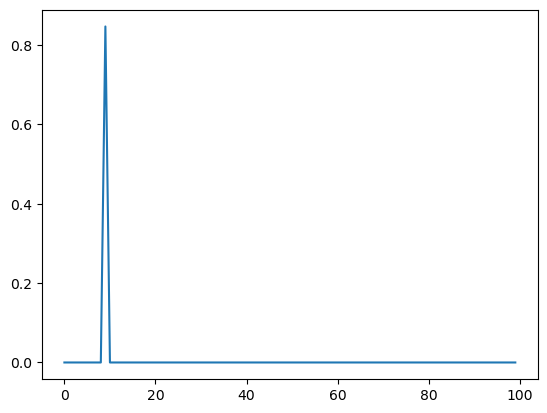

In [10]:
from cohlib.mvcn import thr_coherence
test = thr_coherence(Gamma)
plt.plot(test)

In [11]:
ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj()).mean(3)
xs_ft_outer = np.einsum('lmj,lnj->jmnl', xs_ft,xs_ft.conj()).mean(3)
xys_ft_outer = np.einsum('lmj,lnj->jmnl', xs_ft,ys_ft.conj()).mean(3)

/scratch/264913.1.ood/ipykernel_2405131/3436913063.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(a/b)


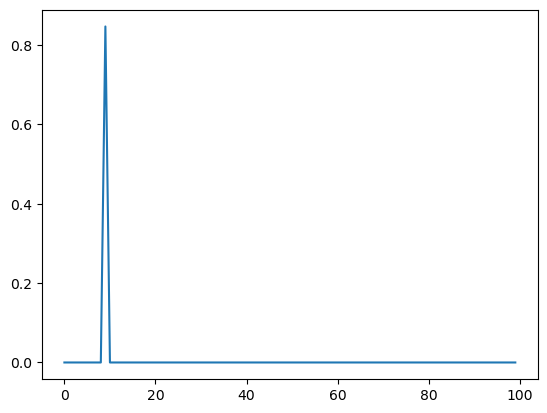

In [12]:
Gamma.shape
a = np.abs(Gamma[:,0,1])**2
b = Gamma[:,0,0].real * Gamma[:,1,1].real
plt.plot(a/b)

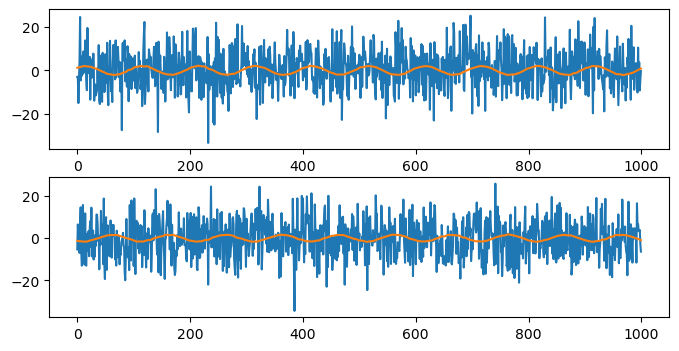

In [13]:
l = 2
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(ys_avg[l,0,:])
ax[1].plot(ys_avg[l,1,:])
ax[0].plot(xs[l,0,:])
ax[1].plot(xs[l,1,:])


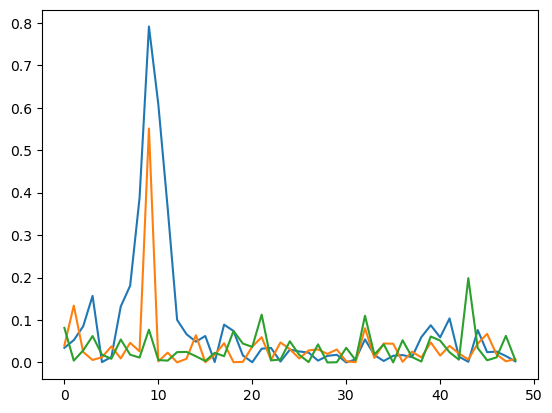

In [14]:
from cohlib.mvcn import estimate_coherence
coh_x1x2 = estimate_coherence(xs_ft[:,0,:], xs_ft[:,1,:])
coh_y1y2 = estimate_coherence(ys_ft[:,0,:], ys_ft[:,1,:])
coh_x1y2 = estimate_coherence(xs_ft[:,0,:], ys_ft[:,1,:])
plt.plot(coh_x1x2[1:50])
plt.plot(coh_y1y2[1:50])
plt.plot(coh_x1y2[1:50])

so we'll want:
- the true coherence of latent (from model)
- oracle coherence from samples x 
- xy coherence
- yy coherence 

but only need mean over C for ys 

In [16]:
from numpy.fft import rfft
from cohlib.mvcn import estimate_coherence
def load_and_calc(func, K, L, sample_length, C, mu, ov1, ov2, estep_type):
    # data_path = f'saved/synthetic_data/simple_synthetic_gaussian_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}'
    data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_1_0.0_1.0_0.0_7'
    data_load = pickle_open(data_path)

    if estep_type == 'approx':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted'
    elif estep_type == 'analytical':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_analytical'
    model_load = pickle_open(model_path)
    print(f'{K} {L} {C} {mu}')

    # ys = data_load['observed']['ys']
    Gamma_true = data_load['latent']['Gamma']
    zs = data_load['latent']['zs']
    xs = data_load['latent']['xs']
    Wv_data = data_load['meta']['Wv']
    freqs = data_load['meta']['freqs']

    ys_avg = model_load['ys_Cavg']
    Wv_model = model_load['Wv']
    Wv = Wv_model
    freqs_mod = freqs[:int((Wv.shape[1] - 1) / 2)]

    J = int((Wv.shape[1]-1)/2)

    # ys_ft = rfft(ys, axis=3).mean(1)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    ys_ft = rfft(ys_avg, axis=2)
    ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    naive = ys_ft_outer.mean(3)
    naive = naive/1000



    func_true = func(Gamma_true[:J_max,:,:])
    func_naive = func(naive[1:J_max+1,:,:])
    model_est = model_load['Gamma']
    func_model = func(model_est)

    direct_est = Gamma_est_from_zs(zs[:,:,:J_max+1], dc=False)
    func_zs = func(direct_est)

    return func_true, func_zs, func_model, func_naive

In [17]:
# great - so next create alg for point process with (known) mu param
# do separate work related to that
# then redo gaussian with no DC and finer range o1 across o2 = 2 / 1
# THEN repeat in point process case 
# then work out analytically why/why not similar 
# - should really calculate the *theoretical spectrum* and show noise-dependence
# finally - thinking about global coh case

In [18]:
J_max

49

In [19]:
L

25

In [20]:
Cs = [1,10,25,500]
ovs = [2.0, 0.0, -2.0]
J_max = 49

num_groups = K
num_trials = L

o1 = 1.0
power1s = np.zeros((len(Cs), len(ovs), 4, J_max))
power1dBs = np.zeros((len(Cs), len(ovs), 4, J_max))
for c, num_neurons in enumerate(Cs):
    for i2, o2 in enumerate(ovs):
        power1_true, power1_zs, power1_model, power1_naive = load_and_calc(get_power1, num_groups, num_trials, 1000, num_neurons, mu, o1, o2, 'analytical')
        power1s[c,i2,0,:] = power1_true
        power1s[c,i2,1,:] = power1_zs[:-1]
        power1s[c,i2,2,:] = power1_model
        power1s[c,i2,3,:] = power1_naive * (2*np.pi)**2

        power1dBs[c,i2,0,:] = 10*np.log10(power1_true)
        power1dBs[c,i2,1,:] = 10*np.log10(power1_zs[:-1])
        power1dBs[c,i2,2,:] = 10*np.log10(power1_model)
        power1dBs[c,i2,3,:] = 10*np.log10(power1_naive * (2*np.pi)**2)

2 25 1 0.0
2 25 1 0.0
2 25 1 0.0
2 25 10 0.0
2 25 10 0.0
2 25 10 0.0
2 25 25 0.0
2 25 25 0.0
2 25 25 0.0
2 25 500 0.0
2 25 500 0.0
2 25 500 0.0


In [27]:
num_em = 10
from numpy.fft import rfft

def plot_power1dB_ov_c():
    fig, ax = plt.subplots(2,3, figsize=(15,6), sharex=False, sharey=True)
    for i1 in range(1):
        for i2 in range(len(ovs)):
            power1dB_true = power1dBs[i1,i2,0,:] 
            power1dB_zs = power1dBs[i1,i2,1,:] 
            power1dB_model = power1dBs[i1,i2,2,:] 
            power1dB_naive = power1dBs[i1,i2,3,:] 

            ax[i1,i2].plot(freqs_mod, power1dB_true, color='k', label='true', linewidth=3)
            ax[i1,i2].plot(freqs_mod, power1dB_naive, linestyle='--', color='tab:red', label='naive')
            ax[i1,i2].plot(freqs_mod, power1dB_zs, color='tab:green', label='direct')
            ax[i1,i2].plot(freqs_mod, power1dB_model, color='tab:blue', linewidth=3, label='model')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, var = 1e{ovs[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            # if i1 == len(Cs)-1:
            ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

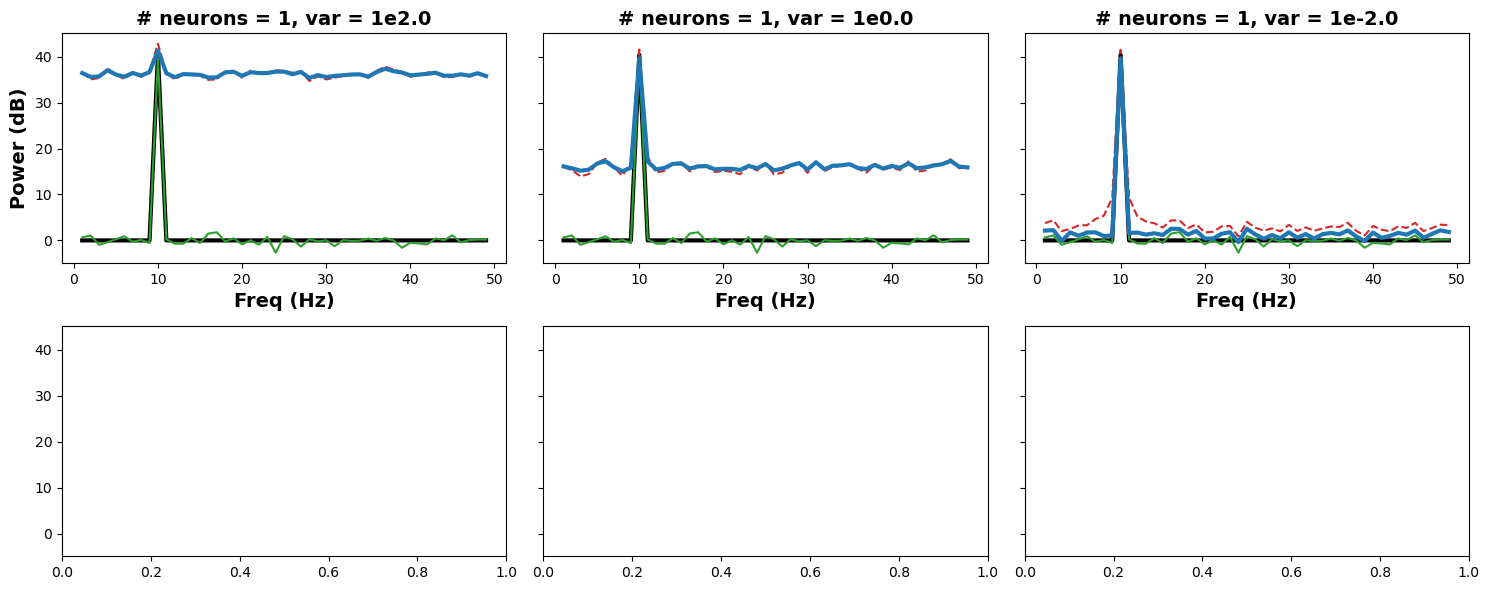

In [28]:
#approx
plot_power1dB_ov_c()

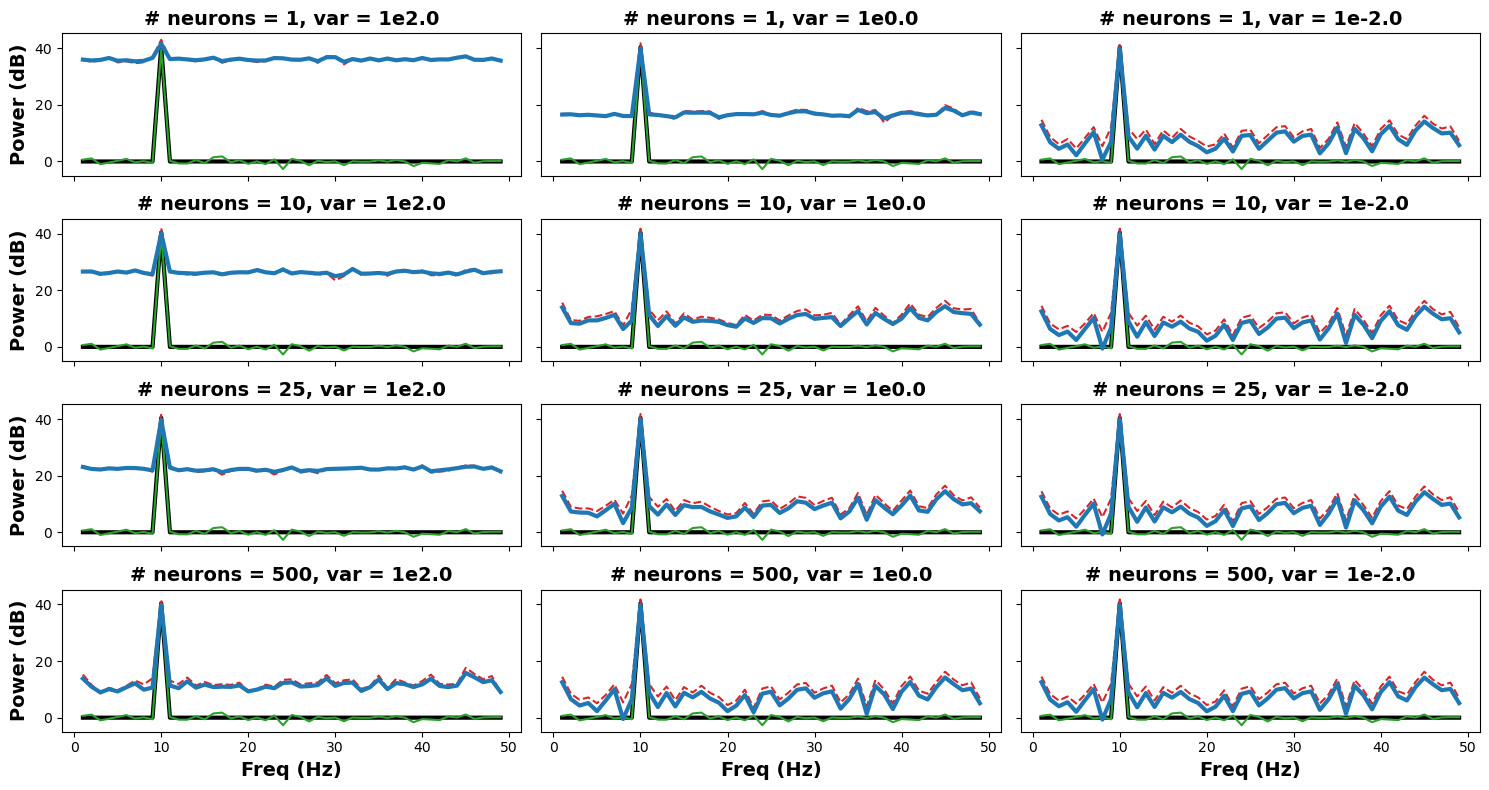

In [74]:
#approx
plot_power1dB_ov_c()

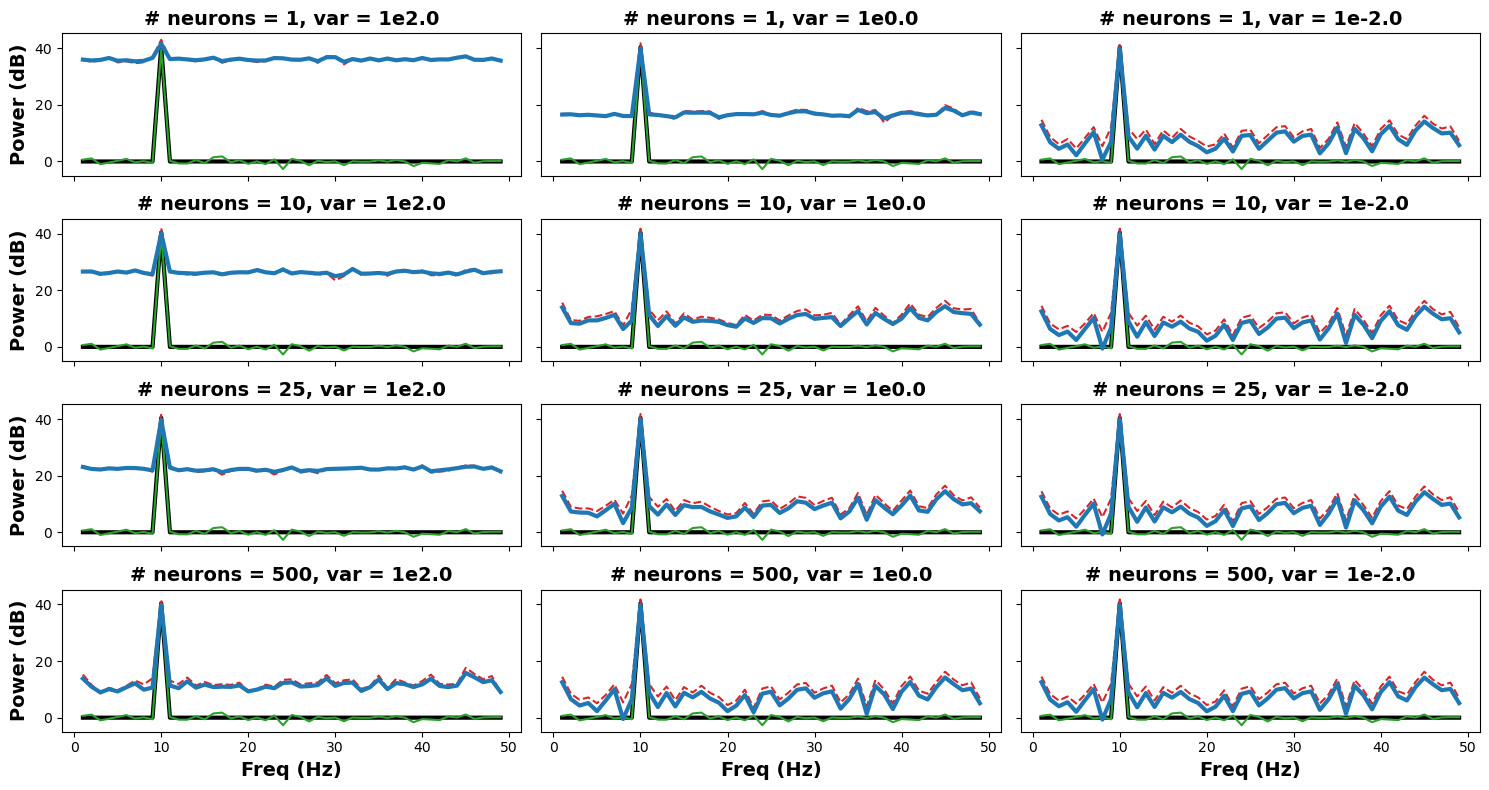

In [ ]:
#approx
plot_power1dB_ov_c()

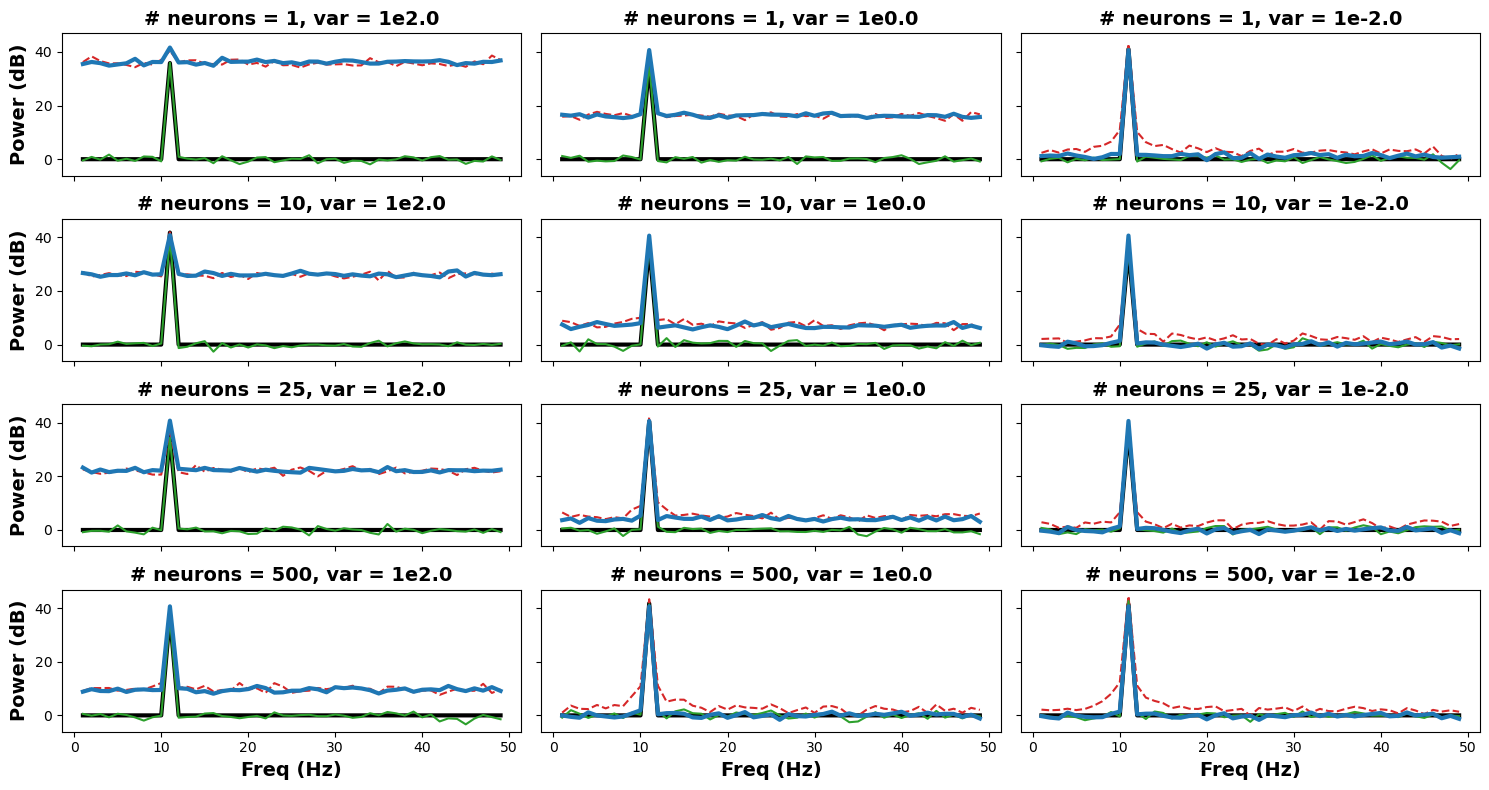

In [18]:
plot_power1dB_ov_c()

In [ ]:
Cs = [1,10,25,500]
ovs = [2.0, 0.0, -2.0]
J_max = 49

num_groups = K
num_trials = L

o1 = 1.0
cohs = np.zeros((len(Cs), len(ovs), 4, J_max))
cohdBs = np.zeros((len(Cs), len(ovs), 4, J_max))
for c, num_neurons in enumerate(Cs):
    for i2, o2 in enumerate(ovs):
        coh_true, coh_zs, coh_model, coh_naive = load_and_calc(get_coh, num_groups, num_trials, 1000, num_neurons, mu, o1, o2, 'analytical')
        cohs[c,i2,0,:] = coh_true
        cohs[c,i2,1,:] = coh_zs
        cohs[c,i2,2,:] = coh_model
        cohs[c,i2,3,:] = coh_naive #* (2*np.pi)**2

        # cohdBs[c,i2,0,:] = 10*np.log10(coh_true)
        # cohdBs[c,i2,1,:] = 10*np.log10(coh_zs)
        # cohdBs[c,i2,2,:] = 10*np.log10(coh_model)
        # cohdBs[c,i2,3,:] = 10*np.log10(coh_naive * (2*np.pi)**2)

2 25 1 0.0
2 25 1 0.0
2 25 1 0.0
2 25 10 0.0
2 25 10 0.0
2 25 10 0.0
2 25 25 0.0
2 25 25 0.0
2 25 25 0.0
2 25 500 0.0
2 25 500 0.0
2 25 500 0.0


In [ ]:
from numpy.fft import rfft

def plot_coh_ov_c():
    fig, ax = plt.subplots(4,3, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(ovs)):
            coh_true = cohs[i1,i2,0,:] 
            coh_zs = cohs[i1,i2,1,:] 
            coh_model = cohs[i1,i2,2,:] 
            coh_naive = cohs[i1,i2,3,:] 

            ax[i1,i2].plot(freqs_mod, coh_true, color='k', label='true', linewidth=3)
            ax[i1,i2].plot(freqs_mod, coh_zs, color='tab:green', label='direct')
            ax[i1,i2].plot(freqs_mod, coh_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, coh_naive, linestyle='--', color='tab:red', label='naive')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, var = 1e{ovs[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

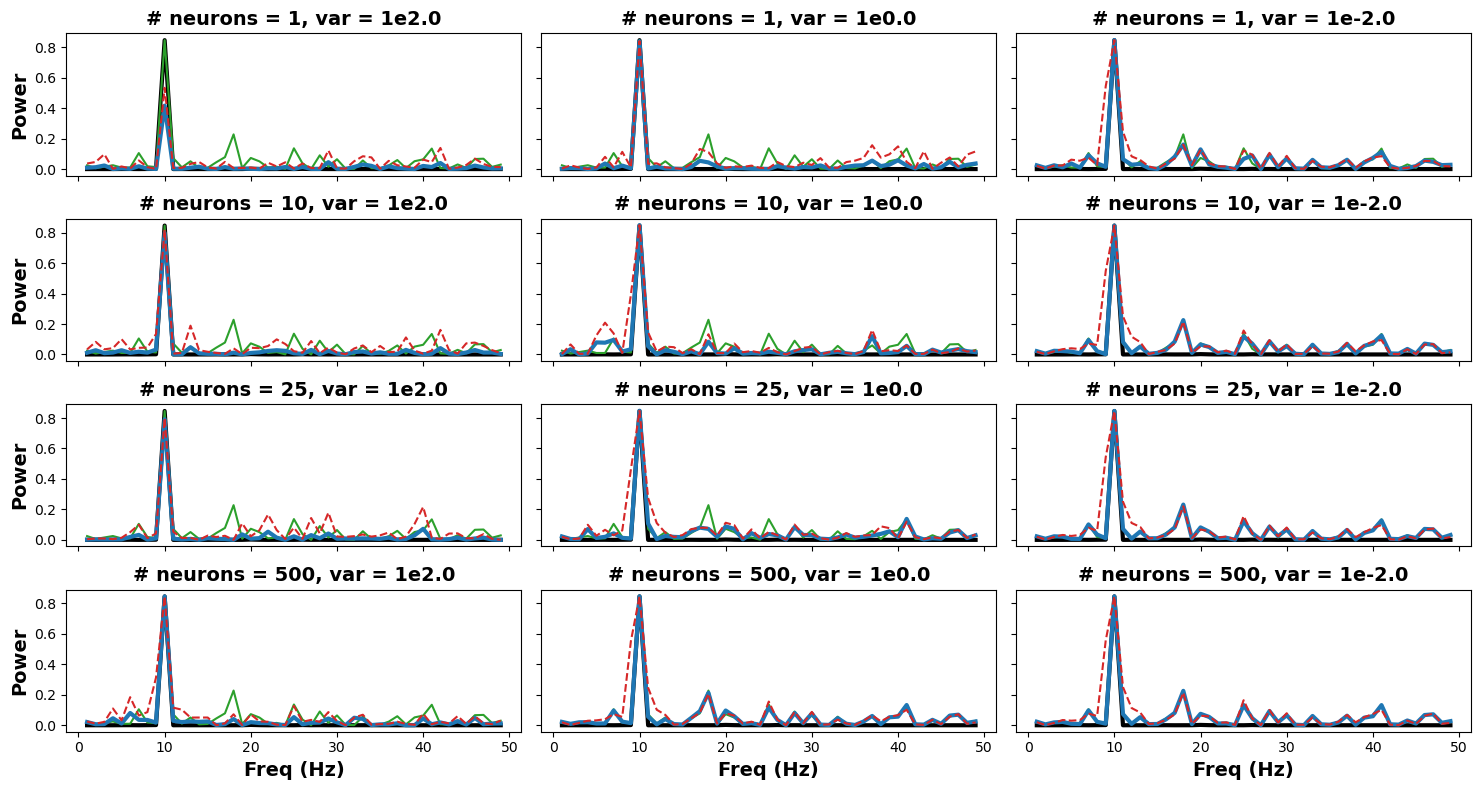

In [ ]:
# approx
plot_coh_ov_c()

In [ ]:
Wv.shape

(1000, 99)

In [ ]:
from numpy.fft import rfft
from cohlib.mvcn import estimate_coherence
def load_and_calc_xy(func, K, L, sample_length, C, mu, ov1, ov2, estep_type, J_max):
    # data_path = f'saved/synthetic_data/simple_synthetic_gaussian_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}'
    data_path = f'saved/synthetic_data/simple_synthetic_gaussian_nodc_{K}_{L}_{sample_length}_1_0.0_1.0_0.0_7'
    data_load = pickle_open(data_path)

    if estep_type == 'approx':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_nodc_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted'
    elif estep_type == 'analytical':
        model_path = f'saved/fitted_models/simple_synthetic_gaussian_nodc_em10_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_analytical'
    model_load = pickle_open(model_path)
    print(f'{K} {L} {C} {ov1} {ov2}')

    # ys = data_load['observed']['ys']
    Gamma_true = data_load['latent']['Gamma']
    zs = data_load['latent']['zs']
    xs = data_load['latent']['xs']
    Wv_data = data_load['meta']['Wv']
    freqs = data_load['meta']['freqs']

    ys_avg = model_load['ys_Cavg']
    Wv_model = model_load['Wv']
    Wv = Wv_model
    # freqs_mod = freqs[:int((Wv.shape[1] - 1) / 2)]
    # J = int((Wv.shape[1]-1)/2)

    freqs_mod = freqs[:int((Wv.shape[1]) / 2)]
    J = int((Wv.shape[1])/2)

    # ys_ft = rfft(ys, axis=3).mean(1)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    xs_ft = rfft(xs, axis=2)
    ys_ft = rfft(ys_avg, axis=2)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    # naive = naive/1000
    coh_naive_xx = estimate_coherence(xs_ft[:,0,1:J_max+1], xs_ft[:,1,1:J_max+1])
    coh_naive_yy = estimate_coherence(ys_ft[:,0,1:J_max+1], ys_ft[:,1,1:J_max+1])
    coh_naive_xy = estimate_coherence(xs_ft[:,0,1:J_max+1], ys_ft[:,1,1:J_max+1])

    # func_naive = func(naive[1:J_max+1,:,:])

    func_true = func(Gamma_true[:J_max,:,:])
    model_est = model_load['Gamma']
    func_model = func(model_est)

    # direct_est = Gamma_est_from_zs(zs[:,:,:J_max+1])
    # func_zs = func(direct_est)

    return func_true, func_model, coh_naive_xx, coh_naive_xy, coh_naive_yy

In [ ]:
from numpy.fft import rfft

def plot_coh_ov_c():
    fig, ax = plt.subplots(4,3, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(ovs)):
            coh_true = cohs[i1,i2,0,:] 
            coh_model = cohs[i1,i2,1,:] 
            coh_naive_xx = cohs[i1,i2,2,:] 
            coh_naive_xy = cohs[i1,i2,3,:] 
            coh_naive_yy = cohs[i1,i2,4,:] 

            # ax[i1,i2].plot(freqs_mod, coh_true, color='k', label='true', linewidth=3)
            # ax[i1,i2].plot(freqs_mod, coh_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, coh_naive_xx, linestyle='--', color='tab:red', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_xy, linestyle='--', color='tab:purple', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:green', label='naive')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, var = 1e{ovs[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

In [ ]:
Cs = [1]
# ovs = [2.0, 0.0, -2.0]
o1s = [10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]
o2s = [2.0, 1.0]
J_max = 49

num_neurons = 1
num_groups = K
num_trials = L

o1 = 1.0
cohs = np.zeros((len(o1s), len(o2s), 5, J_max))
cohdBs = np.zeros((len(o1s), len(o2s), 5, J_max))
for i1, o1 in enumerate(o1s):
    for i2, o2 in enumerate(o2s):
        coh_true, coh_model, coh_naive_xx, coh_naive_xy, coh_naive_yy = load_and_calc_xy(get_coh, num_groups, num_trials, 1000, num_neurons, mu, o1, o2, 'analytical', 49)
        cohs[i1,i2,0,:] = coh_true
        cohs[i1,i2,1,:] = coh_model
        cohs[i1,i2,2,:] = coh_naive_xx #* (2*np.pi)**2
        cohs[i1,i2,3,:] = coh_naive_xy #* (2*np.pi)**2
        cohs[i1,i2,4,:] = coh_naive_yy #* (2*np.pi)**2

        # cohdBs[c,i2,0,:] = 10*np.log10(coh_true)
        # cohdBs[c,i2,1,:] = 10*np.log10(coh_zs)
        # cohdBs[c,i2,2,:] = 10*np.log10(coh_model)
        # cohdBs[c,i2,3,:] = 10*np.log10(coh_naive * (2*np.pi)**2)

2 25 1 10.0 2.0
2 25 1 10.0 1.0
2 25 1 9.0 2.0
2 25 1 9.0 1.0
2 25 1 8.0 2.0
2 25 1 8.0 1.0
2 25 1 7.0 2.0
2 25 1 7.0 1.0
2 25 1 6.0 2.0
2 25 1 6.0 1.0
2 25 1 5.0 2.0
2 25 1 5.0 1.0
2 25 1 4.0 2.0
2 25 1 4.0 1.0
2 25 1 3.0 2.0
2 25 1 3.0 1.0
2 25 1 2.0 2.0
2 25 1 2.0 1.0
2 25 1 1.0 2.0
2 25 1 1.0 1.0


In [ ]:
from numpy.fft import rfft

def plot_coh_ov_c():
    fig, ax = plt.subplots(10,2, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(o1s)):
        for i2 in range(len(o2s)):
            coh_true = cohs[i1,i2,0,:] 
            coh_model = cohs[i1,i2,1,:] 
            coh_naive_xx = cohs[i1,i2,2,:] 
            coh_naive_xy = cohs[i1,i2,3,:] 
            coh_naive_yy = cohs[i1,i2,4,:] 

            # ax[i1,i2].plot(freqs_mod, coh_true, color='k', label='true', linewidth=3)
            # ax[i1,i2].plot(freqs_mod, coh_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, coh_naive_xx, linestyle='--', color='tab:blue', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_xy, linestyle='--', color='tab:green', label='naive')
            ax[i1,i2].plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label='naive')

            ax[i1,i2].set_title(f'# neurons = {1}, var = {o1s[i1]}e{o2s[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Coh', fontweight='bold', fontsize=14)
            if i1 == len(o1s)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

In [ ]:
len(o2s)

2

In [ ]:
cohs.shape

(10, 2, 5, 49)

0.6745962567893342
0.21661237064518926
0.12603589438706247


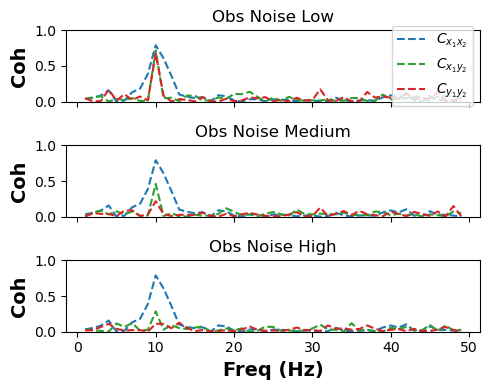

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(5,4), sharex=True, sharey=True)
i1s = []
# o2 = 1
i2 = 0
o1s = [10.0, 5.0, 1.0]

titles = ['Obs Noise Low', 'Obs Noise Medium', 'Obs Noise High']
pairs = [[5,1], [7,0], [0,0]]

for i, pair in enumerate(pairs):
    i1 = pair[0]
    i2 = pair[1]
    coh_naive_xx = cohs[i1,i2,2,:] 
    coh_naive_xy = cohs[i1,i2,3,:] 
    coh_naive_yy = cohs[i1,i2,4,:] 
    print(coh_naive_yy.max())

    ax[i].plot(freqs_mod, coh_naive_xx, linestyle='--', color='tab:blue', label=r'$C_{x_1 x_2}$')
    ax[i].plot(freqs_mod, coh_naive_xy, linestyle='--', color='tab:green', label=r'$C_{x_1 y_2}$')
    ax[i].plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label=r'$C_{y_1 y_2}$')
    ax[i].set_title(titles[i])
    if i == 0:
        ax[i].legend(loc='right')
    ax[i].set_ylabel(f'Coh', fontweight='bold', fontsize=14)
    if i == 2:
        ax[i].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # ax.plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label='naive')
    # ax.plot(freqs_mod, coh_naive_yy, linestyle='--', color='tab:red', label='naive')
    ax[i].set_ylim([0,1])
plt.tight_layout()

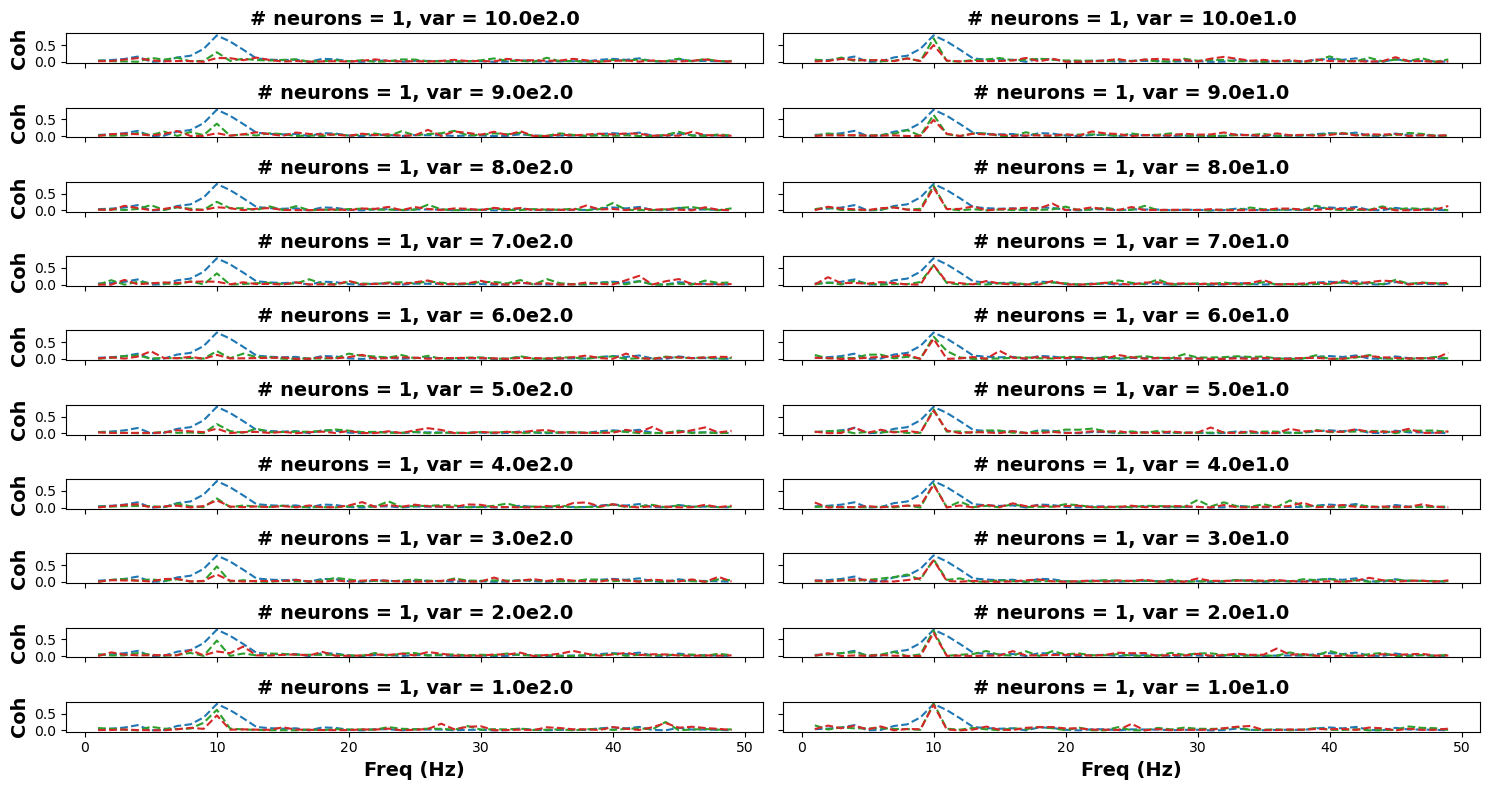

In [ ]:
plot_coh_ov_c()